In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import project_env as pe
import sklearn as sklearn
import math
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from itertools import product
import error_analysis as ea
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

# Target Variable

In [3]:
#target variable of rearrest in 2 years
X_train, y_train = pe.create_target(train, years = 2)
X_val, y_val = pe.create_target(val, years = 2)

In [4]:
unique, counts = np.unique(y_train, return_counts = True)
percent = counts[1]/counts.sum()
print('Training: %s percent were rearrested.' %(percent*100))

unique, counts = np.unique(y_val, return_counts = True)
percent = counts[1]/counts.sum()
print('Test: %s percent were rearrested.' %(percent*100))


Training: 40.3177004539 percent were rearrested.
Test: 40.8131106209 percent were rearrested.


In [5]:
#remove non-feature columns
X_train=X_train.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)
X_val=X_val.drop(['BOFI_NBR','SCREENING_DISP_CODE','UNIQUE_ID','NEXT_ARREST_TIME'], axis=1)

#Using year and month as predictive variables
X_train=X_train.drop(['ARREST_DATE', 'ARREST_DATE_y'], axis=1)
X_val=X_val.drop(['ARREST_DATE','ARREST_DATE_y'], axis=1)

# Gradient Boosted Trees

### Default Parameters

In [6]:
gbt = GradientBoostingClassifier()
gbt = gbt.fit(X_train,y_train)

gbt_pred_train = gbt.predict(X_train)
gbt_pred_val = gbt.predict(X_val)

In [7]:
# gbt accuracy
gbt_accu_train = sklearn.metrics.accuracy_score(y_train,gbt_pred_train)
gbt_accu_test = sklearn.metrics.accuracy_score(y_val,gbt_pred_val)

print("Accuracy on Training Dataset: {}".format(gbt_accu_train))
print("Accuracy on Val Dataset: {}".format(gbt_accu_test))

Accuracy on Training Dataset: 0.6927319717599597
Accuracy on Val Dataset: 0.6870469587141507


In [8]:
gbt_precision = sklearn.metrics.precision_score(y_val,gbt_pred_val)
gbt_recall = sklearn.metrics.recall_score(y_val,gbt_pred_val)
gbt_f_score = sklearn.metrics.f1_score(y_val,gbt_pred_val)

print("Precision: {}".format(gbt_precision))
print("Recall: {}".format(gbt_recall))
print("F-Score: {}".format(gbt_f_score))

Precision: 0.6403867608776497
Recall: 0.5318918918918919
F-Score: 0.5811187041255379


In [9]:
#confusion matrix for val set
gbt_cm = sklearn.metrics.confusion_matrix(y_val,gbt_pred_val)
gbt_cm    #add cm.to_latex?

array([[7456, 1934],
       [3031, 3444]])

In [ ]:
#how do we want this to interact with the error analysis piece? I think those cells should be pasted here.
#another thing - how does this interact with the years and feature selection? Right now you run once for every year and 
#set of features.

### Parameter Optimization

In [132]:
#for the sake of run-times, trying a smaller sample of things:

n_estimators = [50, 100]
learning_rates = [0.1]
max_depths = [3]
min_samples_splits = [2]

In [133]:
model_specs = pd.DataFrame(list(product(n_estimators, learning_rates, max_depths, min_samples_splits)),\
             columns=['n_estimator', 'learning_rate', 'max_depth', 'min_samples_split'])

model_specs['ModelID'] = range(1, len(model_specs)+1)

model_specs['ModelID'] = 'Model' + model_specs['ModelID'].astype(str)

model_specs.head()

,n_estimator,learning_rate,max_depth,min_samples_split,ModelID
0,50,0.1,3,2,Model1
1,100,0.1,3,2,Model2


In [134]:
models = {}

for i in range(len(model_specs)):
    models[model_specs.iloc[i,:]['ModelID']] = \
    GradientBoostingClassifier(n_estimators = int(model_specs.iloc[i,:]['n_estimator']),\
                               learning_rate = float(model_specs.iloc[i,:]['learning_rate']),\
                               max_depth = int(model_specs.iloc[i,:]['max_depth']),\
                               min_samples_split = int(model_specs.iloc[i,:]['min_samples_split'])
                              )

In [135]:
models_fit = {k: v.fit(X_train,y_train) for k, v in models.items()} #after probably 45 mins, not done with the fit stage

In [136]:
models_predict_val = {k: v.predict(X_val) for k, v in models_fit.items()}

In [137]:
model_specs.index = model_specs['ModelID']

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Val Accuracy'] = \
    sklearn.metrics.accuracy_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Precision'] = \
    sklearn.metrics.precision_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'Recall'] = \
    sklearn.metrics.recall_score(y_val, models_predict_val[model_num])

for model_num in list(model_specs['ModelID']):
    model_specs.loc[model_num, 'F-Score'] = \
    sklearn.metrics.f1_score(y_val, models_predict_val[model_num])

In [138]:
model_specs

,n_estimator,learning_rate,max_depth,min_samples_split,ModelID,Val Accuracy,Precision,Recall,F-Score
ModelID,,,,,,,,,
Model1,50,0.1,3,2,Model1,0.681563,0.638236,0.507336,0.565307
Model2,100,0.1,3,2,Model2,0.687047,0.640387,0.531892,0.581119


In [139]:
model_specs.to_csv('gbt_optimization_results.csv')

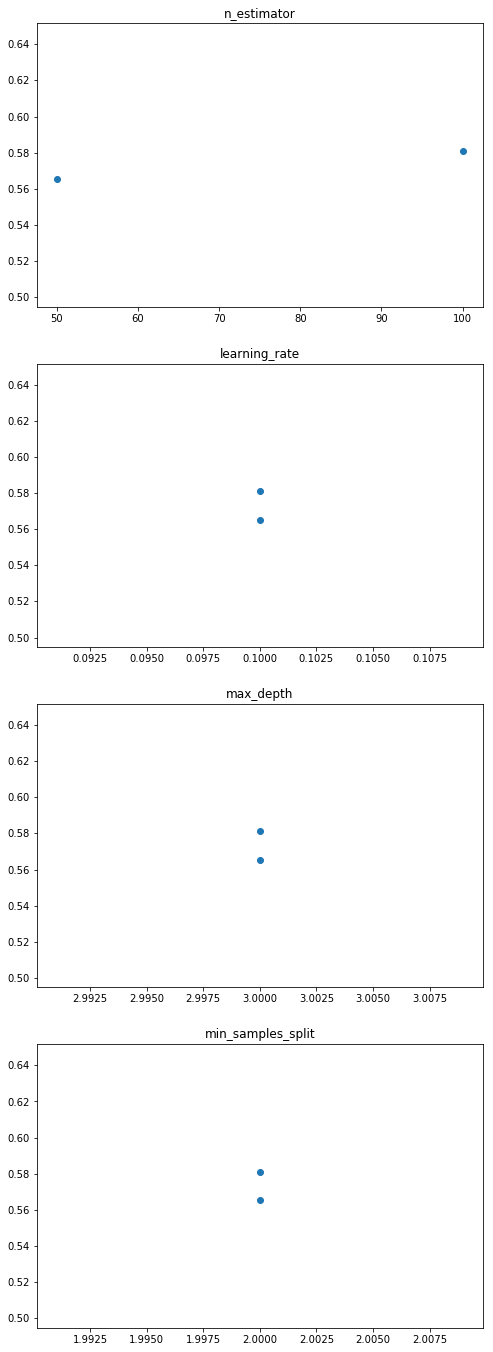

In [140]:
#Plot all the results (these plots will make more sense with 70 models or so)

params = ['n_estimator', 'learning_rate', 'max_depth', 'min_samples_split']

fig, axes = plt.subplots(nrows=len(params), ncols=1)
y = model_specs['F-Score']

for i in range(len(params)):
    x = model_specs[params[i]]
    ax = axes[i]
    ax.set_title(params[i])
    ax.scatter(x, y)

plt.gcf().set_size_inches(8,24) 
plt.savefig('gbt_opt_plot.png')
matplotlib.pyplot.show()

### Error Analysis (Perform on the best model)

In [146]:
len(models_predict_val['Model1'])

15865

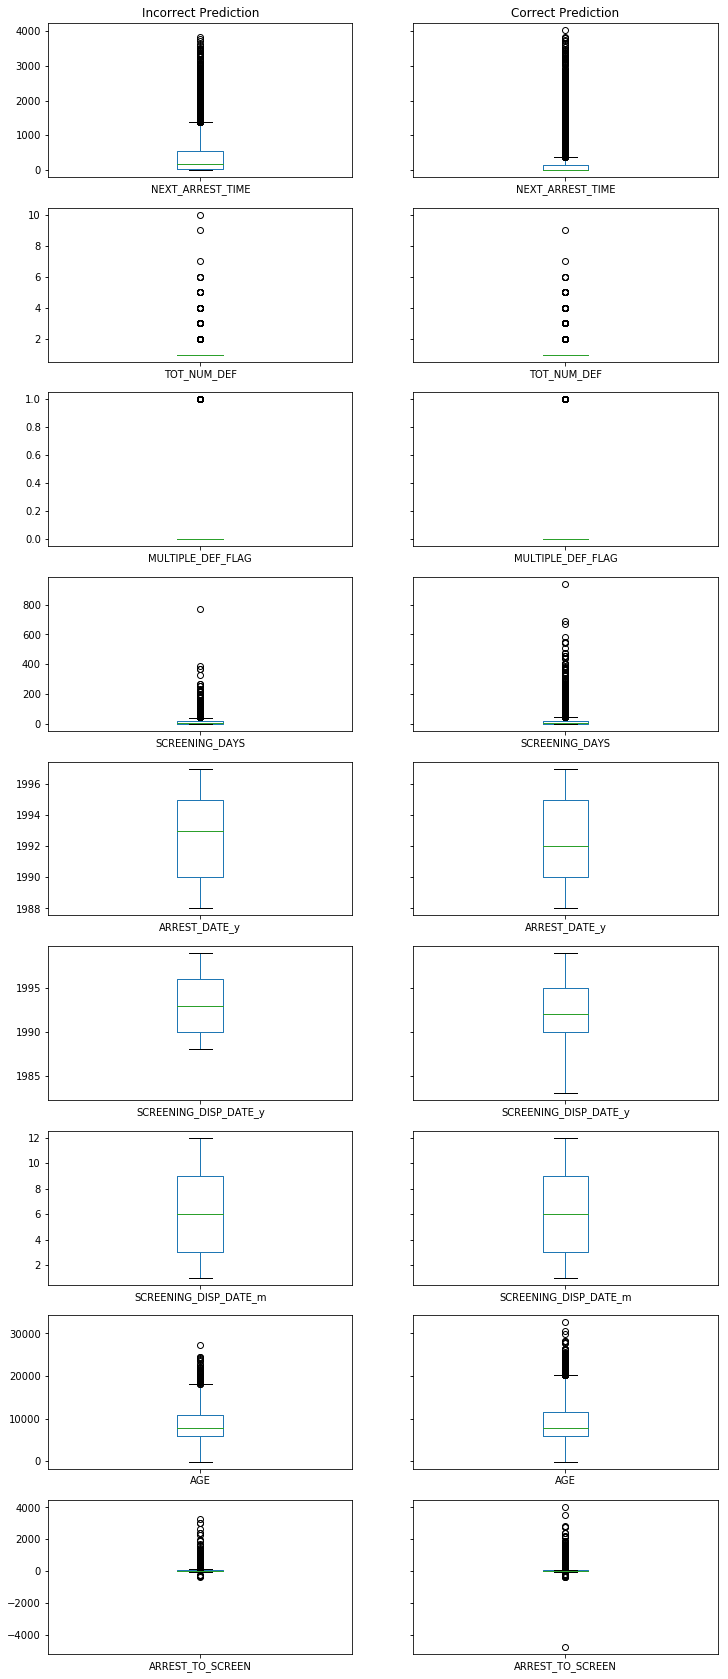

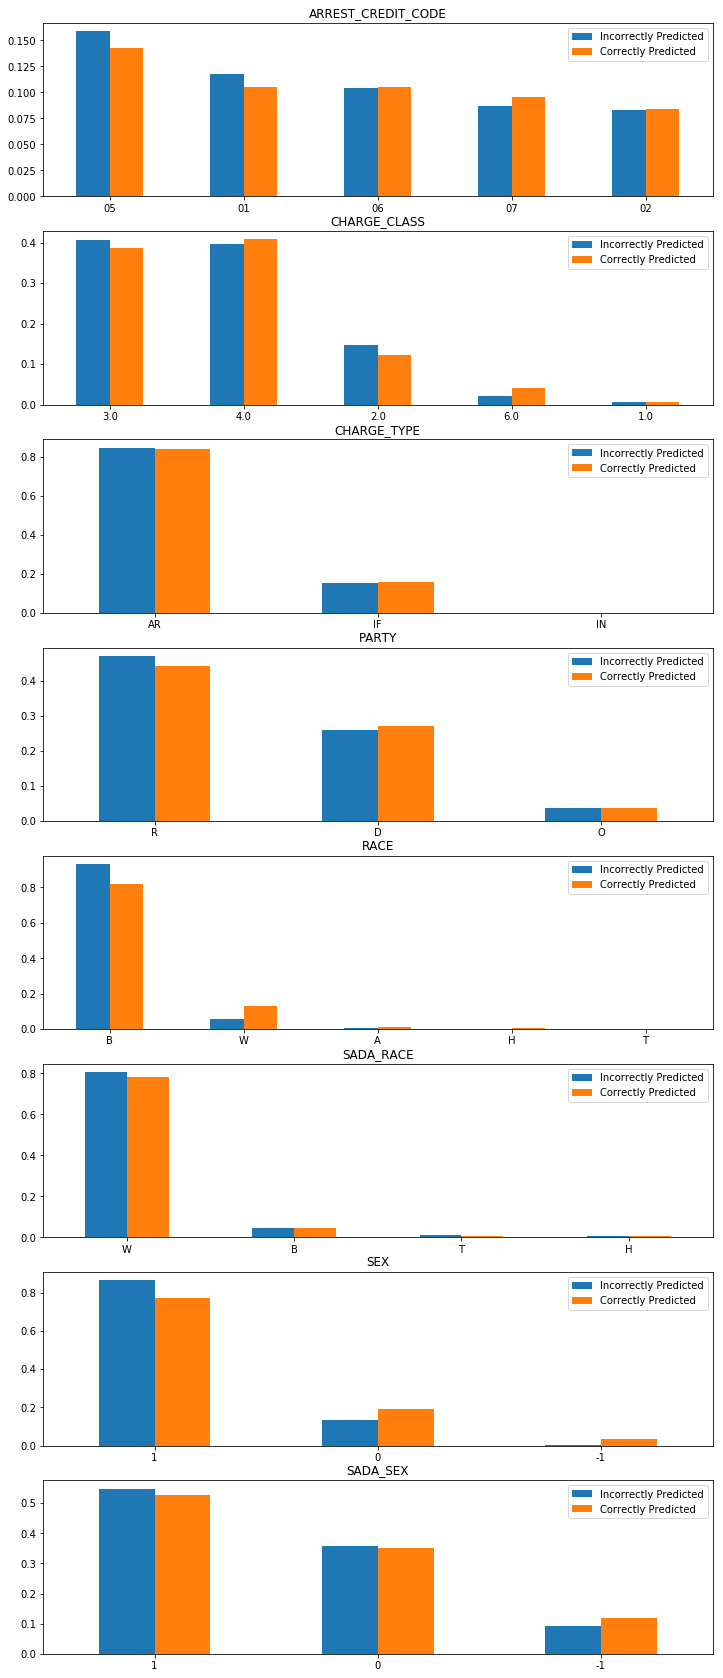

In [147]:
preds_to_analyze = models_predict_val['Model1']

np.save('pred_val_2yr_gbt.npy', preds_to_analyze)

numeric = ['NEXT_ARREST_TIME','CRIMINAL_FLAG','FINAL_DETENTION_FLAG','HABITUAL_OFFENDER_FLAG',\
           'INITIAL_DETENTION_FLAG','JUVENILE_FLAG','TOT_NUM_DEF','MULTIPLE_DEF_FLAG','SCREENING_DAYS',\
           'ARREST_DATE_y','SCREENING_DISP_DATE_y',\
           'SCREENING_DISP_DATE_m', 'AGE', 'ARREST_TO_SCREEN']

numeric_exc_binary = ['NEXT_ARREST_TIME','TOT_NUM_DEF','MULTIPLE_DEF_FLAG','SCREENING_DAYS',\
           'ARREST_DATE_y','SCREENING_DISP_DATE_y',\
           'SCREENING_DISP_DATE_m', 'AGE', 'ARREST_TO_SCREEN']

categorical =['ARREST_CREDIT_CODE', 'CHARGE_CLASS', 'CHARGE_TYPE',\
       'PARTY', 'RACE', 'SADA_RACE','SEX','SADA_SEX']

val_error = ea.Error_Analysis('2_yr_gbt', 'data_val.csv', 'pred_val_2yr_gbt.npy')

val_error.all_error_analysis(2, numeric_exc_binary, numeric, categorical)

# Random Forest

### Default Parameters

In [148]:
rf_clf =  RandomForestClassifier()
rf_clf = rf_clf.fit(X_train,y_train)

rf_pred_train = rf_clf.predict(X_train)
rf_pred_val = rf_clf.predict(X_val)

In [ ]:
RandomForestClassifier()

In [149]:
#a rf ccuracy
rf_accu_train = sklearn.metrics.accuracy_score(y_train,rf_pred_train)
rf_accu_test = sklearn.metrics.accuracy_score(y_val,rf_pred_val)

print("Accuracy on Training Dataset: {}".format(rf_accu_train))
print("Accuracy on Val Dataset: {}".format(rf_accu_test))

Accuracy on Training Dataset: 0.980064926878467
Accuracy on Val Dataset: 0.6518121651433975


In [12]:
rf_precision = sklearn.metrics.precision_score(y_val,rf_pred_val)
rf_recall = sklearn.metrics.recall_score(y_val,rf_pred_val)
rf_f_score = sklearn.metrics.f1_score(y_val,rf_pred_val)

print("Precision: {}".format(rf_precision))
print("Recall: {}".format(rf_recall))
print("F-Score: {}".format(rf_f_score))

Precision: 0.5926903553299493
Recall: 0.4508108108108108
F-Score: 0.5121052631578948


In [13]:
#confusion matrix for val set
rf_cm = sklearn.metrics.confusion_matrix(y_val,rf_pred_val)
rf_cm    #add cm.to_latex?

array([[7384, 2006],
       [3556, 2919]])

### Parameter Optimization

n_estimators = [50, 100, 500]
max_features = ['sqrt','log2']
max_depths = [3,5]
min_samples_splits = [2,4,8]

In [206]:
#Reduced Number of Options for Run-times

n_estimators = [10, 50, 100]
max_features = ['sqrt','log2']
max_depths = [4, 8, 12]
min_samples_splits = [2, 4, 8]

In [207]:
model_specs_rf = pd.DataFrame(list(product(n_estimators, max_features, max_depths, min_samples_splits)),\
             columns=['n_estimator', 'max_features', 'max_depth', 'min_samples_split'])

model_specs_rf['ModelID'] = range(1, len(model_specs_rf)+1)

model_specs_rf['ModelID'] = 'Model' + model_specs_rf['ModelID'].astype(str)

model_specs_rf.head()

,n_estimator,max_features,max_depth,min_samples_split,ModelID
0,10,sqrt,4,2,Model1
1,10,sqrt,4,4,Model2
2,10,sqrt,4,8,Model3
3,10,sqrt,8,2,Model4
4,10,sqrt,8,4,Model5


In [208]:
models_rf = {}

for i in range(len(model_specs_rf)):
    models_rf[model_specs_rf.iloc[i,:]['ModelID']] = \
    RandomForestClassifier(n_estimators = int(model_specs_rf.iloc[i,:]['n_estimator']),\
                               max_features = model_specs_rf.iloc[i,:]['max_features'],\
                               max_depth = model_specs_rf.iloc[i,:]['max_depth'],\
                               min_samples_split = int(model_specs_rf.iloc[i,:]['min_samples_split'])
                              )

In [210]:
models_fit_rf = {k: v.fit(X_train,y_train) for k, v in models_rf.items()}

In [211]:
models_predict_val_rf = {k: v.predict(X_val) for k, v in models_fit_rf.items()}

In [212]:
model_specs_rf.index = model_specs_rf['ModelID']

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'Val Accuracy'] = \
    sklearn.metrics.accuracy_score(y_val, models_predict_val_rf[model_num])

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'Precision'] = \
    sklearn.metrics.precision_score(y_val, models_predict_val_rf[model_num])

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'Recall'] = \
    sklearn.metrics.recall_score(y_val, models_predict_val_rf[model_num])

for model_num in list(model_specs_rf['ModelID']):
    model_specs_rf.loc[model_num, 'F-Score'] = \
    sklearn.metrics.f1_score(y_val, models_predict_val_rf[model_num])

/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [214]:
#creates a numeric version of the max_features parameter

model_specs_rf['max_features_number']= \
np.where(model_specs_rf['max_features']=='sqrt', math.sqrt(X_train.shape[1]), math.log(X_train.shape[1],2))

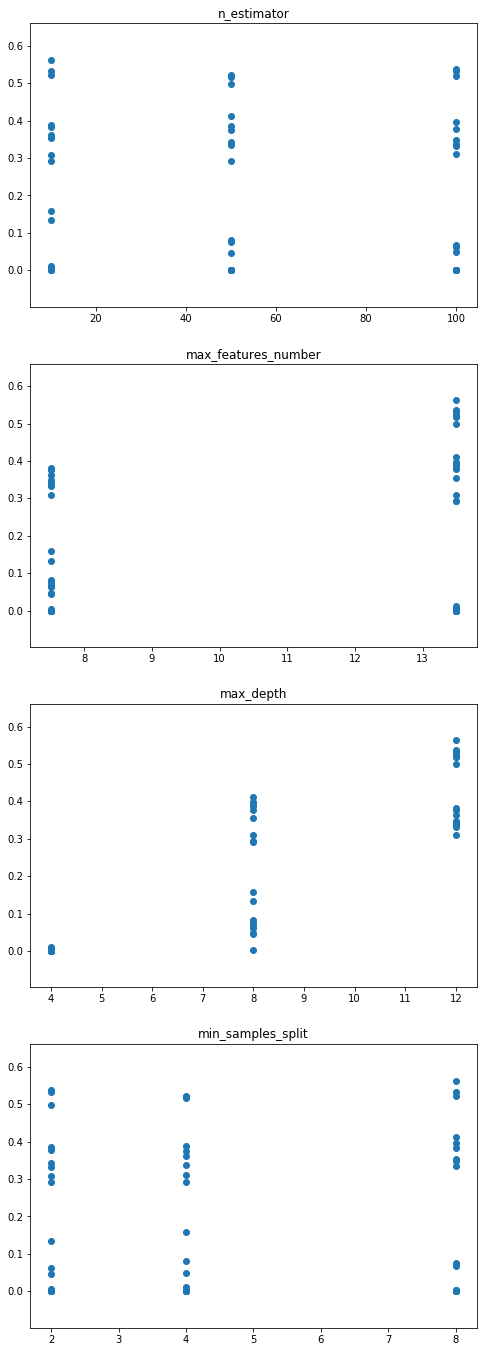

In [215]:
#Plot all the results

params = ['n_estimator', 'max_features_number', 'max_depth', 'min_samples_split']

fig, axes = plt.subplots(nrows=len(params), ncols=1)
y = model_specs_rf['F-Score']

for i in range(len(params)):
    x = model_specs_rf[params[i]]
    ax = axes[i]
    ax.set_title(params[i])
    ax.scatter(x, y)

plt.gcf().set_size_inches(8,24) 
matplotlib.pyplot.show()